In [39]:
# !pip install pmdarima

In [41]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [42]:
indexes = []
all_indexes = {}

In [ ]:
all_indexes = pd.read_excel('../Data/Index_Data.xlsx', sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

In [44]:
BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170,-0.014103,0.017844,0.000030,-0.017502,11,2,2025
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606,-0.000225,0.014211,0.003563,-0.010498,12,2,2025
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422,-0.000815,0.009881,0.007394,-0.002463,13,2,2025
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624,-0.005888,0.013831,0.001231,-0.012428,14,2,2025
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759,0.004699,0.009924,0.005295,-0.004583,17,2,2025


In [45]:
BSESN['Date'] = pd.to_datetime(BSESN['Date'])
BSESN = BSESN.sort_values('Date').reset_index(drop=True)

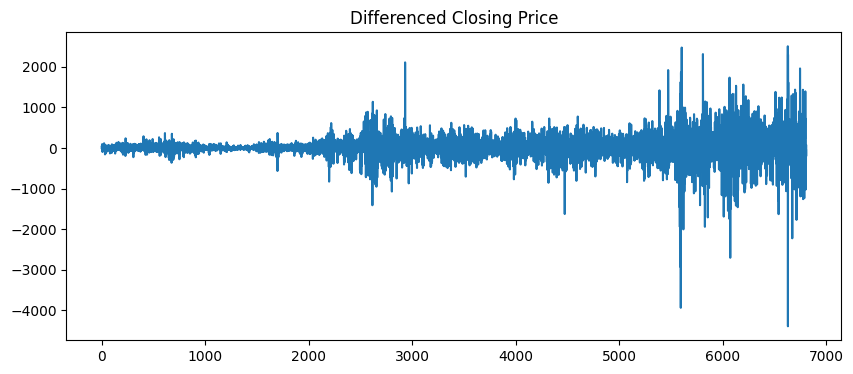

In [46]:
df = BSESN['Close']
train = df[:-365]
test = df[-365:]

diff = df.diff().dropna()
diff.plot(title="Differenced Closing Price", figsize=(10, 4))
plt.show()

In [47]:
# stepwise_model = auto_arima(df, seasonal=False, trace=True)
# stepwise_model.summary()

In [48]:
# Fit ARIMA with selected (p,d,q)
model = ARIMA(train, order=(5, 2, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6443
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -46025.193
Date:                Sun, 13 Apr 2025   AIC                          92062.387
Time:                        17:24:20   BIC                          92103.009
Sample:                             0   HQIC                         92076.443
                               - 6443                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8051      0.005   -154.975      0.000      -0.815      -0.795
ar.L2         -0.6437      0.007    -86.613      0.000      -0.658      -0.629
ar.L3         -0.4984      0.009    -58.242      0.0

In [49]:
forecast = model_fit.forecast(steps=365)

In [50]:
test_df = pd.DataFrame({"test":test})
test_df = test_df.reset_index(drop=True)

predicted_df = pd.DataFrame({"forecast":forecast})
predicted_df = predicted_df.reset_index(drop=True)

comparison_df = pd.concat([test_df, predicted_df], axis=1)
comparison_df['difference'] = comparison_df['test'] - comparison_df['forecast']

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mae = mean_absolute_error(comparison_df['test'], comparison_df['forecast'])

print(f"MAE: {mae}")

MAE: 2260.677233081536


In [52]:
import numpy as np

def calculate_r_squared(y_true, y_pred):
    """
    Calculate R-squared (R²) value manually.

    Parameters:
    - y_true: Actual values (true target variable values).
    - y_pred: Predicted values (from your model).

    Returns:
    - R² value: Coefficient of determination.
    """
    # Convert to numpy arrays if not already in that format
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the mean of the actual values
    y_mean = np.mean(y_true)

    # Total sum of squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)

    # Residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)

    return r_squared

calculate_r_squared(comparison_df['test'], comparison_df['forecast'])

0.7163284107579244

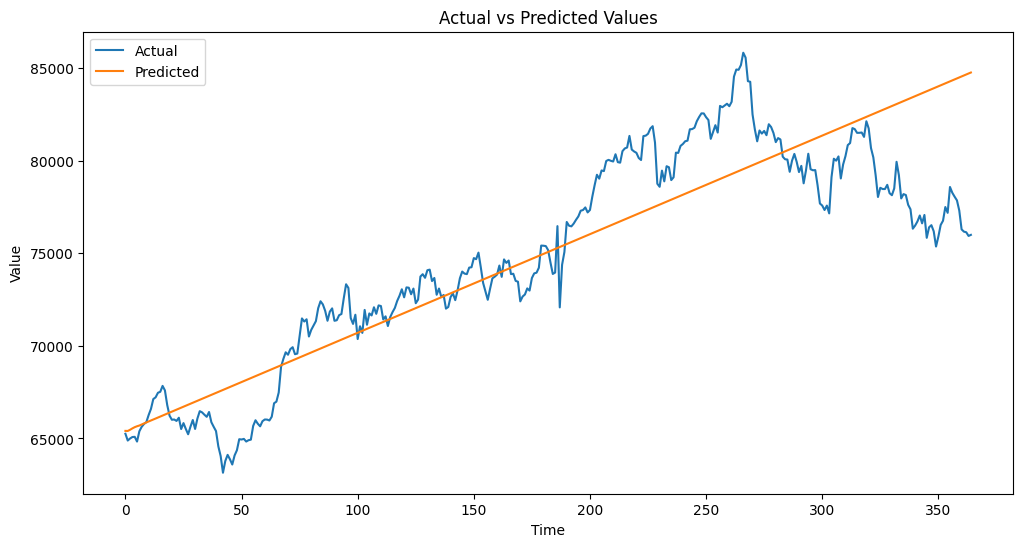

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['test'], label='Actual')
plt.plot(comparison_df['forecast'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [54]:
comparison_df

,test,forecast,difference
0,65252.339844,65408.054718,-155.714874
1,64886.511719,65404.400149,-517.888430
2,64996.601562,65468.113906,-471.512343
3,65075.820312,65543.208658,-467.388345
4,65087.250000,65609.060096,-521.810096
...,...,...,...
360,76293.601562,84554.073783,-8260.472220
361,76171.078125,84607.324976,-8436.246851
362,76138.968750,84660.576169,-8521.607419
363,75939.210938,84713.827362,-8774.616424
